In [48]:
from typing import Dict, List, Tuple, Union
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import random
import json
import numpy as np
import time
import seaborn as sns
from IPython.display import display
import pandas as pd

## Class Documentation: BayesNode

The `BayesNode` class represents a node in a Bayesian network. Each node has a name, a list of parent nodes, and a list of child nodes.

In [49]:
class BayesNode:
    def __init__(self, name: str) -> None:
        self.name = name
        self.parents: List['BayesNode'] = []
        self.children: List['BayesNode'] = []

    def add_parent(self, parent: 'BayesNode') -> None:
        self.parents.append(parent)

    def add_child(self, child: 'BayesNode') -> None:
        self.children.append(child)

    def __repr__(self) -> str:
        return self.name

    def __str__(self) -> str:
        return self.name

    def __hash__(self) -> int:
        return hash(self.name)

    def __eq__(self, other: 'BayesNode') -> bool:
        return self.name == other.name

## Class Documentation: BayesNetwork

The `BayesNetwork` class represents a Bayesian Network, a type of probabilistic graphical model that represents a set of variables and their conditional dependencies. 

Each node in the network represents a random variable, while the edges between the nodes represent probabilistic dependencies among the corresponding random variables. The network is initialized with a structure and probabilities, both represented as dictionaries.

The class provides methods to add nodes to the network, establish parent-child relationships between nodes, and visualize the structure of the network.

The `show_structure` method uses the `networkx` and `matplotlib` libraries to draw the network. Nodes are represented as circles, and edges are represented as arrows pointing from parent nodes to child nodes.

In [50]:
class BayesNetwork:
    def __init__(self, structure : Dict[str, Dict[str, List[str]]], probabilities : Dict[str, Union[float, Dict]]) -> None:
        self.nodes: Dict[str, BayesNode] = {}
        self.node_values: Dict[str, int] = {}
        self.counter = {}
        self.probabilities = probabilities
        self.initialize_structure(structure)

    def has_node(self, node_name: str) -> bool:
        return node_name in self.nodes

    def get_node(self, node_name: str) -> BayesNode:
        if self.has_node(node_name):
            return self.nodes[node_name]

    def add_node(self, node_name: str) -> BayesNode:
        if not self.has_node(node_name):
            new_node = BayesNode(node_name)
            self.nodes[node_name] = new_node
        return self.get_node(node_name)

    def add_parent_child_relationship(self, parent_node: BayesNode, child_node: BayesNode) -> None:
        if child_node not in parent_node.children:
            parent_node.add_child(child_node)
            child_node.add_parent(parent_node)

    def initialize_structure(self, structure: Dict[str, Dict[str, List[str]]]) -> None:
        for node_name, relationships in structure.items():
            current_node = self.add_node(node_name)
            for parent in relationships['Parents']:
                parent_node = self.add_node(parent)
                self.add_parent_child_relationship(parent_node, current_node)
            for child in relationships['Children']:
                child_node = self.add_node(child)
                self.add_parent_child_relationship(current_node, child_node)

    def show_structure(self) -> None:
        G = nx.DiGraph()
        for node_name, node in self.nodes.items():
            G.add_node(node_name)
            for child in node.children:
                G.add_edge(node_name, child.name)

        pos = graphviz_layout(G, prog='dot')
        nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=5000, font_size=16, font_weight='bold', edge_color='gray')
        plt.margins(0.1)
        plt.show()

## Class Documentation: GibbsSampler

The `GibbsSampler` class implements the Gibbs Sampling algorithm, a Markov chain Monte Carlo (MCMC) method used for approximating the joint probability distribution for a system of variables. It is particularly useful in Bayesian networks.

The class is initialized with a `BayesNetwork` object and a domain of possible values for the variables in the network.

The `run` method executes the Gibbs Sampling algorithm. It takes as input a dictionary of evidences (known values), a query variable, and the number of iterations to run the algorithm. It returns a dictionary representing the approximate distribution of the query variable.

In [51]:
class GibbsSampler:
    def __init__(self, bayes_network : BayesNetwork, domain : List[str]) -> None:
        self.bayes_network = bayes_network
        self.domain = domain

    def run(self, evidences : Dict[str, bool], query_variable : str, iterations: int) -> Dict[str, int]:
        self.initialize_values(evidences, self.domain)
        self.initialize_counters(query_variable, self.domain)
        for _ in range(iterations):
            node = self.generate_not_evidence_node(evidences)
            probabilities = self.calculate_conditional_probabilities(node, self.domain)
            new_value = self.sample(probabilities)
            self.bayes_network.node_values[node.name] = new_value
            self.bayes_network.counter[(query_variable, self.bayes_network.node_values[query_variable])] += 1
        return self.normalize(self.bayes_network.counter, iterations)

    def calculate_conditional_probabilities(self, node : BayesNode, domain : List[str]) -> Dict[Tuple[str, str], float]:
        result = {}
        for value in domain:
            if node.parents:
                handler = [value]
                for parent in sorted(node.parents, key=lambda x: x.name):
                    handler.append(parent.name)
                    handler.append(self.bayes_network.node_values[parent.name])
                result[value] = self.get_nested_value(self.bayes_network.probabilities[node.name], handler)
            else:
                result[value] = self.bayes_network.probabilities[node.name][value]

            for child in sorted(node.children, key=lambda x: x.name):
                handler = [value]
                for parent in sorted(child.parents, key=lambda x: x.name):
                    handler.append(parent.name)
                    handler.append(self.bayes_network.node_values[parent.name])
                result[value] *= self.get_nested_value(self.bayes_network.probabilities[child.name], handler)
        return result

    def normalize(self, counter: Dict[Tuple[str, int], int], iterations: int) -> Dict[Tuple[str, str], float]:
        result = {}
        for value, count in counter.items():
            result[value] = count / iterations
        return result

    def sample(self, probabilities: Dict[int, float]) -> int:
        total = sum(probabilities.values())
        rand_val = random.uniform(0, total)
        cumulative = 0
        for value, probability in probabilities.items():
            cumulative += probability
            if rand_val <= cumulative:
                return value
        return value

    def initialize_values(self, evidences: Dict[str, bool], domain : List[str]) -> None:
        for node in self.bayes_network.nodes:
            if node in evidences:
                self.bayes_network.node_values[node] = str(int(evidences[node]))
            else:
                self.bayes_network.node_values[node] = random.choice(domain)

    def generate_not_evidence_node(self, evidences : Dict[str, bool]) -> BayesNode:
        not_evidence_nodes = [node for node in self.bayes_network.nodes.values() if node.name not in evidences]
        node = random.choice(not_evidence_nodes)
        return node

    def initialize_counters(self, query_variable : str, domain : List[int]) -> None:
        for value in domain:
            self.bayes_network.counter[(query_variable, value)] = 0

    def get_nested_value(self, dictionary: dict, keys: list) -> float:
        for key in keys:
            if isinstance(dictionary, dict) and key in dictionary:
                dictionary = dictionary[key]
            else:
                return None
        return float(dictionary)

In [52]:
def read_json_file(file_path: str) -> dict:
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [53]:
evidences = read_json_file("evidences.json")
probabilities = read_json_file("probabilities.json")
structure = read_json_file("bayes_structure.json")

Structure JSON file represents a Bayesian network structure. A Bayesian network is a type of probabilistic graphical model that uses Bayesian inference for probability computations. Bayesian networks aim to model conditional dependence, and therefore causation, by representing conditional dependence by edges in a directed graph.

Here's a description of the JSON structure:

- Each key in the JSON object represents a node in the Bayesian network. In this case, the nodes are "Magda Calls", "Burglary", "Alarm", "John Calls", and "Earthquake".
- Each node has two properties: "Parents" and "Children", which are both arrays. These represent the relationships between the nodes in the Bayesian network.
- The "Parents" array for a node contains the names of all nodes that have an edge pointing to the node. These are the nodes that the current node is conditionally dependent upon.
- The "Children" array for a node contains the names of all nodes that the node has edges pointing to. These are the nodes that are conditionally dependent on the current node.

In [54]:
structure_df = pd.json_normalize(structure)
display(structure_df)

,Magda Calls.Parents,Magda Calls.Children,Burglary.Parents,Burglary.Children,Alarm.Parents,Alarm.Children,John Calls.Parents,John Calls.Children,Earthquake.Parents,Earthquake.Children
0,[Alarm],[],[],[Alarm],"[Burglary, Earthquake]","[John Calls, Magda Calls]",[Alarm],[],[],[Alarm]


Evidences JSON file represents a set of evidences or observations in a Bayesian network. In the context of Bayesian networks, an evidence is an observed event, i.e., a variable that we have observed and know the outcome of.

Here's a description of the JSON structure:

- Each key in the JSON object represents a node in the Bayesian network. In this case, the nodes are "Burglary" and "Earthquake".
- The value associated with each key represents the observed outcome for that node. In this case, "Burglary" is `true` and "Earthquake" is `false`.

This means that in the observed evidence, a burglary has occurred (since "Burglary" is `true`), and there has not been an earthquake (since "Earthquake" is `false`). This evidence can be used to update the probabilities of the other nodes in the Bayesian network using Bayesian inference.

In [55]:
evidences_df = pd.json_normalize(evidences)
display(evidences_df)

,Burglary,Earthquake
0,True,False


Probabilities JSON file represents the conditional probability tables (CPTs) for each node in a Bayesian network. In the context of Bayesian networks, a CPT for a node gives the probability of each possible value of the node given each possible combination of values of its parent nodes.

Here's a description of the JSON structure:

- Each key in the JSON object represents a node in the Bayesian network. In this case, the nodes are "Burglary", "Earthquake", "Alarm", "John Calls", and "Magda Calls".
- The value associated with each key is another JSON object that represents the CPT for that node.
- For nodes without parents (like "Burglary" and "Earthquake"), the CPT simply gives the probability of the node being `true` ("1") and `false` ("0").
- For nodes with parents (like "Alarm", "John Calls", and "Magda Calls"), the CPT is a nested JSON object that gives the probability of the node being `true` ("1") and `false` ("0") for each possible combination of values of its parent nodes.

In [56]:
probabilities_df = pd.json_normalize(probabilities)
display(probabilities_df)

,Burglary.1,Burglary.0,Earthquake.1,Earthquake.0,Alarm.1.Burglary.1.Earthquake.1,Alarm.1.Burglary.1.Earthquake.0,Alarm.1.Burglary.0.Earthquake.1,Alarm.1.Burglary.0.Earthquake.0,Alarm.0.Burglary.1.Earthquake.1,Alarm.0.Burglary.1.Earthquake.0,Alarm.0.Burglary.0.Earthquake.1,Alarm.0.Burglary.0.Earthquake.0,John Calls.1.Alarm.1,John Calls.1.Alarm.0,John Calls.0.Alarm.1,John Calls.0.Alarm.0,Magda Calls.1.Alarm.1,Magda Calls.1.Alarm.0,Magda Calls.0.Alarm.1,Magda Calls.0.Alarm.0
0,0.01,0.99,0.02,0.98,0.95,0.94,0.29,0.001,0.05,0.06,0.71,0.999,0.9,0.05,0.1,0.95,0.7,0.01,0.3,0.99


This Python code is an example of how to use my implementation of the Gibbs Sampler to estimate the probability distribution of the some variable in a Bayesian Network, given some evidence. The Bayesian Network is defined by its structure and probabilities. The structure, probabilities and evidence are all represented as JSON files described above. You can run the MCMC algorithm using the run method of the GibbsSampler class.

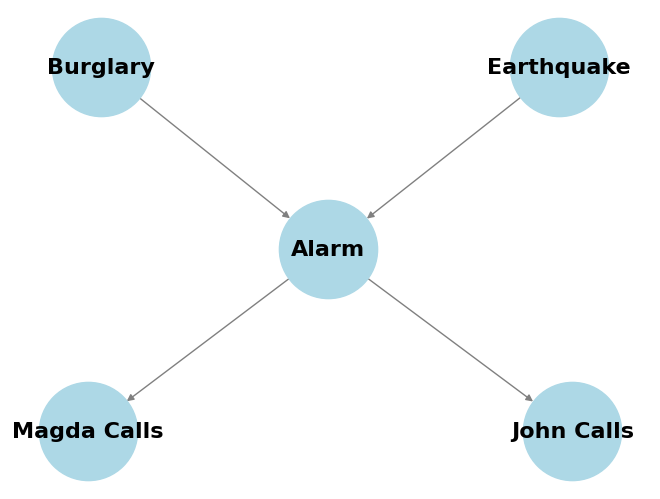

{('John Calls', '0'): 0.267, ('John Calls', '1'): 0.733}


In [57]:
query_variable = "John Calls"
domain = ['0', '1']

bayes_network = BayesNetwork(structure, probabilities)
bayes_network.show_structure()

gibbs_sampler = GibbsSampler(bayes_network, domain)
result = gibbs_sampler.run(evidences, query_variable, 10000)
print(result)

In [58]:
def draw_graphs(gibbs_sampler, query_variable, evidences):
    sns.set_context("talk")
    colors = sns.color_palette("husl", 8)
    num_of_iterations = np.linspace(10, 5000, 50)
    results_0 = []
    results_1 = []
    times = []

    for i in num_of_iterations:
        temp_0 = []
        temp_1 = []
        temp_time = []
        for _ in range(600):
            start = time.time()
            result = gibbs_sampler.run(evidences, query_variable, int(i))
            stop = time.time()
            temp_0.append(result[(query_variable, '0')])
            temp_1.append(result[(query_variable, '1')])
            temp_time.append(stop - start)
        results_0.append(temp_0)
        results_1.append(temp_1)
        times.append(temp_time)

    avg_results_0 = [np.mean(res) for res in results_0]
    avg_results_1 = [np.mean(res) for res in results_1]
    std_results_0 = [np.std(res) for res in results_0]
    std_results_1 = [np.std(res) for res in results_1]
    avg_time = [np.mean(t) for t in times]

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    axs[0].grid(True)
    axs[1].grid(True)

    axs[0].plot(num_of_iterations, avg_results_0, label='0', color=colors[0], linewidth=2)
    axs[0].fill_between(num_of_iterations, np.subtract(avg_results_0, std_results_0), np.add(avg_results_0, std_results_0), color=colors[0], alpha=0.1)
    axs[0].plot(num_of_iterations, avg_results_1, label='1', color=colors[1], linewidth=2)
    axs[0].fill_between(num_of_iterations, np.subtract(avg_results_1, std_results_1), np.add(avg_results_1, std_results_1), color=colors[1], alpha=0.1)
    axs[0].set_title(f'Probability of {query_variable}')
    axs[0].set_xlabel('Number of iterations')
    axs[0].set_ylabel('Probability')
    axs[0].legend()

    axs[1].plot(num_of_iterations, avg_time, color=colors[2], linewidth=2)
    axs[1].set_title('Execution Time')
    axs[1].set_xlabel('Number of iterations')
    axs[1].set_ylabel('Time [s]')

    evidence_text = "\n".join([f"{key}: {value}" for key, value in evidences.items()])
    axs[1].text(0.02, 0.95, f"Evidences:\n{evidence_text}", transform=axs[1].transAxes, fontsize=12, verticalalignment='top', bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    fig.suptitle('Gibbs Sampler Results and Execution Time')

    plt.tight_layout()
    plt.show()

Conclusions from the graphs:

- The execution time of the algorithm increases linearly with the number of iterations.
- A small number of iterations does not yield good results.
- Only after about 2000 iterations do the results start to stabilize and the distribution of the query variable becomes apparent.
- In our case, the variable "John Calls", given the known values of burglary = 1 and earthquake = 0, has a distribution of approximately 65% for 1 and 35% for 0.

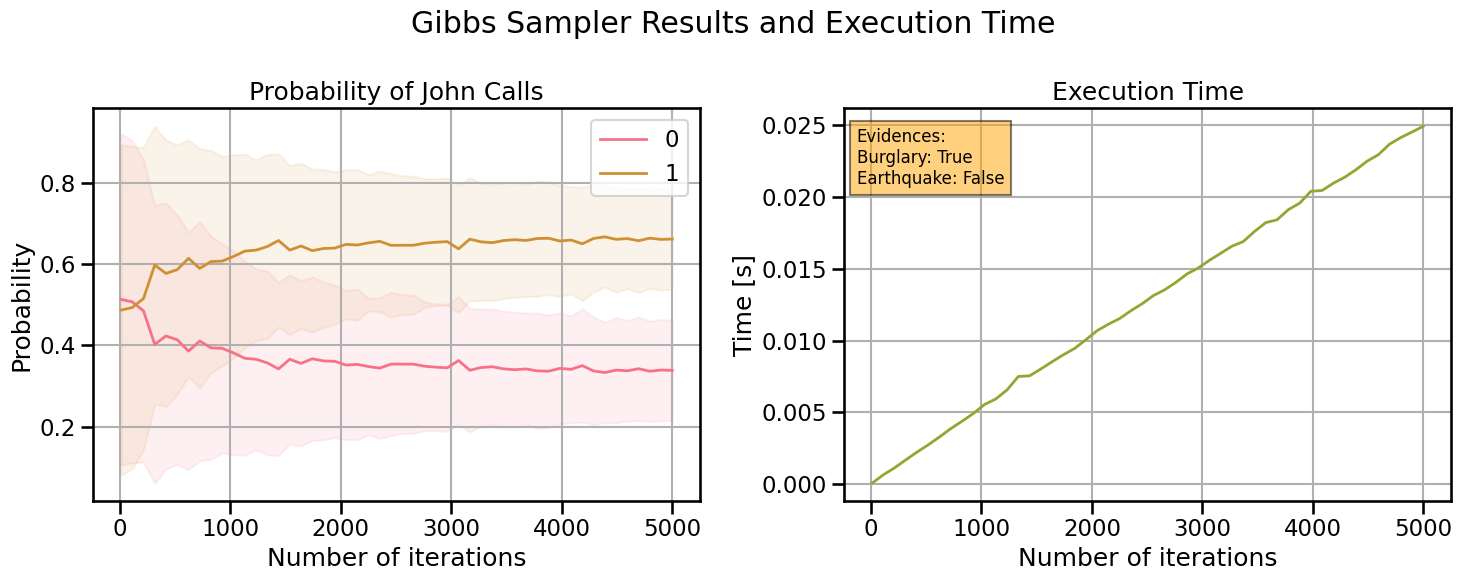

In [59]:
evidences = read_json_file("evidences.json")
probabilities = read_json_file("probabilities.json")
structure = read_json_file("bayes_structure.json")
query_variable = "John Calls"
domain = ['0', '1']
bayes_network = BayesNetwork(structure, probabilities)
gibbs_sampler = GibbsSampler(bayes_network, domain)
draw_graphs(gibbs_sampler, query_variable, evidences)